# Installation

In [1]:
!pip install -q "openvino-dev>=2023.0.0"
!pip install -q "python-ffmpeg<=1.0.16" moviepy transformers onnx onnxruntime
!pip install -q -I "git+https://github.com/garywu007/pytube.git"
!pip install -q "optimum-intel[openvino,diffusers]" "ipywidgets"
!pip install -q "diffusers>=0.16.1" "transformers>=4.28.0"
!pip install -q "git+https://github.com/huggingface/optimum-intel.git" datasets gradio

from IPython import display
display.clear_output()

In [1]:
from pathlib import Path
from openvino.runtime import Core, Tensor
import numpy as np

In [2]:
ie = Core()

In [3]:
#Select your device
import ipywidgets as widgets

device_names = [f"{device}: {ie.get_property(device, 'FULL_DEVICE_NAME')}" 
                for device in ie.available_devices]

print("Available devices: \n", device_names)

device = widgets.Dropdown(
    options=ie.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)
device

Available devices: 
 ['CPU: Intel(R) Xeon(R) Silver 4416+', 'GPU: Intel(R) Data Center GPU Flex 170 (dGPU)']


Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

# Step 1: "Say it" with Whisper!
## Step 1.1: Setup

In [ ]:
REPO_DIR = Path("whisper")
if not REPO_DIR.exists():
    !git clone https://github.com/openai/whisper.git -b v20230124
!cd whisper && pip install .

display.clear_output()

In [4]:
from collections import namedtuple
from functools import partial
from utils.whisper_OV_utils import *
from utils.whisper_preprocess_utils import *

In [5]:
#TBD - get audio input
#For now, please use pre-recorded audio files
audio_file = Path("mountain.wav")

In [6]:
#Download whisper base model
import whisper
model = whisper.load_model("base")
model.to("cpu")
model.eval()
pass
#Delete the model encoder and decoder
#to replace with OV versions
del model.decoder
del model.encoder

In [7]:
Parameter = namedtuple('Parameter', ['device'])
def parameters():
    return iter([Parameter(torch.device('cpu'))])

In [9]:
model.encoder = OpenVINOAudioEncoder(ie, 'whisper_models/whisper_encoder.xml', device=device.value)
model.decoder = OpenVINOTextDecoder(ie, 'whisper_models/whisper_decoder.xml', device=device.value)
model.decode = partial(decode, model)
model.parameters = parameters
model.logits = partial(logits, model)

## Step 1.2: Run the pipeline

In [10]:
audio = resample_wav(audio_file)

In [11]:
transcription = model.transcribe(audio, beam_size=5, best_of=5, task="translate")

2023-08-14 16:47:38.447157: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-14 16:47:38.449175: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 16:47:38.484185: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 16:47:38.484910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 16:47:38.933976: W tensorflow/compiler/tf2t

In [12]:
srt_lines = prepare_srt(transcription)
# save transcription
with audio_file.with_suffix(".srt").open("w") as f:
    f.writelines(srt_lines)

In [13]:
widgets.Audio.from_file(audio_file, loop=False)

Audio(value=b'RIFF\x90\xac\x12\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x02\x00D\xac\x00\x00\x10\xb1\x02\x00\x04\x0…

In [14]:
transcribed_txt = "".join(srt_lines)
print(transcribed_txt)

 a mountain landscape in an impressionist style.


# Step 2: "Refine it" with DOLLY

In [27]:
prompt = f"Write a prompt for a art generating AI model with the phrase '{transcribed_txt}' \
Your answer should be a single, artistic sentence that adds text to the specified phrase." #
prompt

"Write a prompt for a art generating AI model with the phrase ' a mountain landscape in an impressionist style.' Your answer should be a single, artistic sentence that adds text to the specified phrase."

In [28]:
from utils.dolly_if_utils import *

In [29]:
from pathlib import Path
from transformers import AutoTokenizer
from optimum.intel.openvino import OVModelForCausalLM

model_id = "databricks/dolly-v2-3b"
model_path = Path("dolly-v2-3b")

tokenizer = AutoTokenizer.from_pretrained(model_id)

current_device = device.value

if model_path.exists():
    ov_model = OVModelForCausalLM.from_pretrained(model_path, device=current_device)
else:
    print("Model path does not exist.")

Compiling the model...
Set CACHE_DIR to dolly-v2-3b/model_cache


Note - debug needed - when setting device to "AUTO": RuntimeError: Exception from src/inference/src/core.cpp:246:
[ GENERAL_ERROR ] Check 'internal_properties.find(name) != internal_properties.end()' failed at src/plugins/auto/src/plugin_config.cpp:67:
[AUTO] not supported property INFERENCE_PRECISION_HINT

In [30]:
INSTRUCTION_KEY = "### Instruction:"
RESPONSE_KEY = "### Response:"
END_KEY = "### End"
INTRO_BLURB = (
    "Below is an instruction that describes a task. Write a response that appropriately completes the request. \
    Do not write more than one sentence."
)

# This is the prompt that is used for generating responses using an already trained model.  It ends with the response
# key, where the job of the model is to provide the completion that follows it (i.e. the response itself).
PROMPT_FOR_GENERATION_FORMAT = """{intro}

{instruction_key}
{instruction}

{response_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    response_key=RESPONSE_KEY,
)

In [31]:
end_key_token_id = get_special_token_id(tokenizer, RESPONSE_KEY, END_KEY)

In [32]:
# Prepare input prompt according to model expected template
prompt_text = PROMPT_FOR_GENERATION_FORMAT.format(instruction=prompt)

# Tokenize the user text.
model_inputs = tokenizer(prompt_text, return_tensors="pt")
generate_ids = ov_model.generate(model_inputs.input_ids,
        max_new_tokens=100,
        do_sample=True,
        top_p=0.99,
        temperature=float(1.0),
        top_k=20,
        eos_token_id=end_key_token_id)

output_text = tokenizer.batch_decode(generate_ids)[0]
output_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


"Below is an instruction that describes a task. Write a response that appropriately completes the request.     Do not write more than one sentence.\n\n### Instruction:\nWrite a prompt for a art generating AI model with the phrase'a mountain landscape in an impressionist style.' Your answer should be a single, artistic sentence that adds text to the specified phrase.\n\n### Response:\nA faint outline of a town in the distance, with mountains in the distance and some trees in the foreground.\n\n### End"

In [35]:
refined_txt = output_text.split("Response:\n", 1)[1].replace('\n\n### End', '')

In [36]:
#refined_txt =  transcribed_txt + refined_txt
refined_txt

'A faint outline of a town in the distance, with mountains in the distance and some trees in the foreground.'

# Step 3: "See it" with Stable Diffusion XL Refiner!

Debug needed: Issue with GPU (?)

In [38]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline, OVStableDiffusionXLPipeline
import numpy as np
    
model_dir = Path("openvino-sd-xl-base-1.0")
refiner_model_dir = Path("openvino-sd-xl-refiner-1.0")

base = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)
refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_dir, device=device.value)

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder...
Compiling the vae_encoder...
Compiling the text_encoder_2...
Compiling the vae_decoder...
Compiling the unet...
Compiling the vae_encoder...
Compiling the text_encoder_2...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

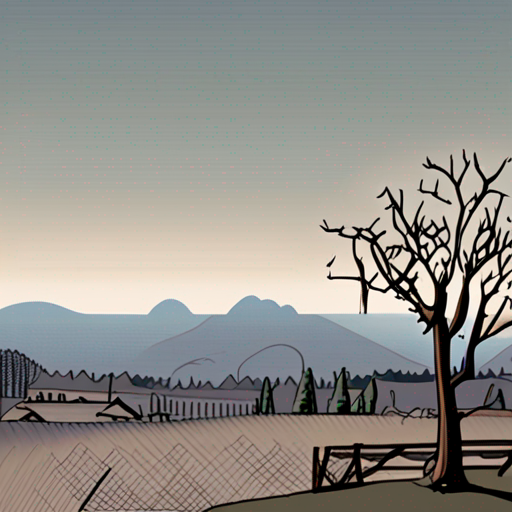

In [39]:
latents = base(refined_txt, num_inference_steps=15, height=512, width=512, 
               generator=np.random.RandomState(314), output_type="latent").images[0]

image = refiner(prompt=refined_txt, image=latents[None, :], num_inference_steps=15, 
                generator=np.random.RandomState(314)).images[0]

image.save("sd_result.png")

image

# Step 4: "Understand it" with CLIP!

In [42]:
from transformers import CLIPProcessor

model_checkpoint = "openai/clip-vit-base-patch16"
processor = CLIPProcessor.from_pretrained(model_checkpoint)

In [43]:
from openvino.runtime import Core

core = Core()

text_model = core.read_model("clip/clip-vit-base-patch16_text.xml")
image_model = core.read_model("clip/clip-vit-base-patch16_image.xml")
text_model = core.compile_model(model=text_model, device_name=device.value)
image_model = core.compile_model(model=image_model, device_name=device.value)

In [44]:
from PIL import Image
from utils.clip_utils import *

query = "Where is the brightest part of the image?"
image = Image.open("sd_result.png")
n_iters = 300
min_crop_size = 50

  0%|          | 0/300 [00:00<?, ?it/s]

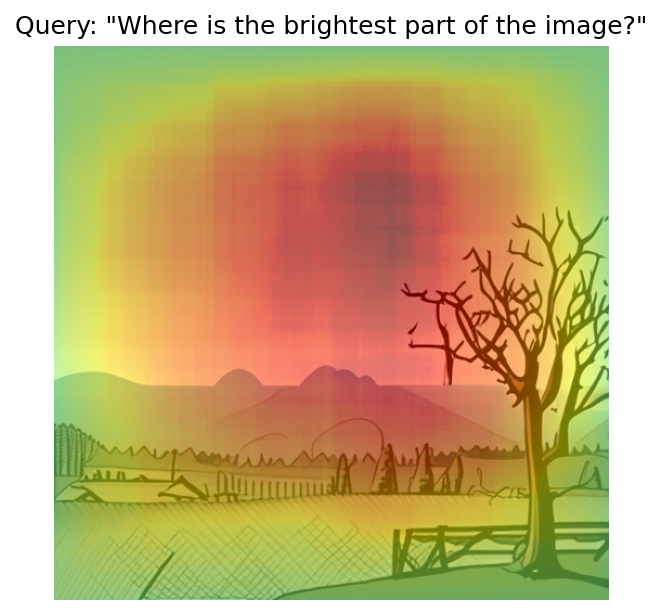

In [45]:
im_tensor = np.array(image)
x_dim, y_dim = image.size
text_inputs = dict(
    processor(text=[query], images=[im_tensor], return_tensors="np")
)
image_inputs = text_inputs.pop("pixel_values")

text_embeds = text_model(text_inputs)[text_model.output()]
image_embeds = image_model(image_inputs)[image_model.output()]

initial_similarity = cosine_similarity(text_embeds, image_embeds)
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)

    image_inputs = processor(images=[im_crop], return_tensors="np").pixel_values
    image_embeds = image_model(image_inputs)[image_model.output()]

    similarity = cosine_similarity(text_embeds, image_embeds) - initial_similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)

plot_saliency_map(im_tensor, saliency_map, query)